In [1]:
# -*- coding: utf-8 -*-
"""Sequential_Model_Scratch.ipynb"""

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow-addons
!pip install tensorflow

import tensorflow as tf
from zipfile import ZipFile
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("TensorFlow Version:", tf.__version__)

Saving alzheimers-dataset-4-class-of-images-metadata.json to alzheimers-dataset-4-class-of-images-metadata (1).json
User uploaded file "alzheimers-dataset-4-class-of-images-metadata (1).json" with length 3446 bytes
mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
alzheimers-dataset-4-class-of-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00
TensorFlow Version: 2.15.0


In [2]:


file_name = "/content/alzheimers-dataset-4-class-of-images.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall("/content/")
    print('Done')
    extracted_dir = "/content/Alzheimer_s Dataset"
print("Contents of extracted directory:")
print(os.listdir(extracted_dir))

AUTOTUNE = tf.data.experimental.AUTOTUNE
base_dir = "/content/Alzheimer_s Dataset"
train_dir = os.path.join(extracted_dir, "train")
test_dir = os.path.join(extracted_dir, "test")

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 299
IMAGE_SIZE = [299, 299]
DIM = (IMG_SIZE, IMG_SIZE)

BATCH_SIZE = 32

# Set a random seed for reproducibility
seed_value = 1337

Done
Contents of extracted directory:
['train', 'test']


In [3]:


# Create separate data generators for training and validation with augmentation
train_datagen = IDG(
    rescale=1./255,
    zoom_range=[.99, 1.01],
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='constant',
    validation_split=0.2,
    data_format='channels_last'
)


In [4]:

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assuming you're doing multi-class classification
    subset='training',
    seed=seed_value
)

Found 4098 images belonging to 4 classes.


In [5]:


val_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assuming you're doing multi-class classification
    subset='validation',
    seed=seed_value
)


Found 1023 images belonging to 4 classes.


<ipython-input-6-9733edb6e864>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')


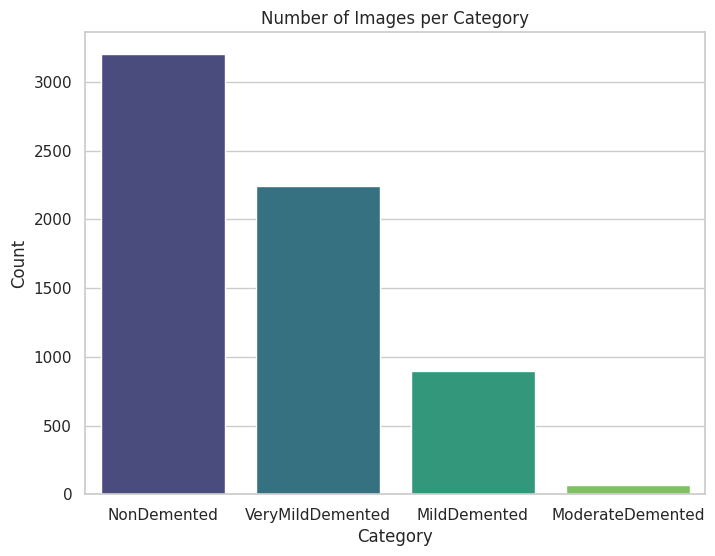

In [6]:

# Count images per category
datasets = ["train", "test"]
counts = {cls: 0 for cls in CLASSES}
for dataset in datasets:
    for cls in CLASSES:
        counts[cls] += len(glob.glob(os.path.join(extracted_dir, dataset, cls, '*.jpg')))

data = {'Category': list(counts.keys()), 'Count': list(counts.values())}
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')
ax.set_title('Number of Images per Category')
plt.show()


In [7]:

# Class weights
total_samples = sum(counts.values())
class_weights = {i: total_samples / (4 * count) for i, count in enumerate(counts.values())}

# New section: Sequential model from scratch with 12 layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Initialize a Sequential model
model_scratch = Sequential()

# Add layers
model_scratch.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(128, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(256, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))


model_scratch.add(Flatten())

model_scratch.add(Dense(512, activation='relu'))
model_scratch.add(Dropout(0.5))

model_scratch.add(Dense(256, activation='relu'))
model_scratch.add(Dropout(0.5))

model_scratch.add(Dense(128, activation='relu'))
model_scratch.add(Dropout(0.5))

model_scratch.add(Dense(64, activation='relu'))
model_scratch.add(Dropout(0.5))
model_scratch.add(BatchNormalization())

model_scratch.add(Dense(len(CLASSES), activation='softmax'))


In [8]:

# Compile the model
model_scratch.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print the model summary
model_scratch.summary()

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                        

In [9]:
# Train the model
history_scratch = model_scratch.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // BATCH_SIZE,
    epochs=20,
    validation_data=val_ds,
    validation_steps=val_ds.samples // BATCH_SIZE,
    class_weight=class_weights,  # Utilize the calculated class weights
    callbacks=[reduce_lr]
)

Epoch 1/20
128/128 [==============================] - 150s 995ms/step - loss: 14.1081 - accuracy: 0.2681 - val_loss: 1.5650 - val_accuracy: 0.3508 - lr: 0.0010
Epoch 2/20
128/128 [==============================] - 111s 865ms/step - loss: 7.5384 - accuracy: 0.3333 - val_loss: 1.8584 - val_accuracy: 0.3478 - lr: 0.0010
Epoch 3/20
128/128 [==============================] - 133s 1s/step - loss: 5.2444 - accuracy: 0.3406 - val_loss: 2.0040 - val_accuracy: 0.3538 - lr: 0.0010
Epoch 4/20
128/128 [==============================] - 132s 1s/step - loss: 4.4690 - accuracy: 0.3490 - val_loss: 1.9284 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 5/20
128/128 [==============================] - 112s 874ms/step - loss: 4.0372 - accuracy: 0.3527 - val_loss: 1.8982 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 6/20
128/128 [==============================] - 108s 842ms/step - loss: 3.8895 - accuracy: 0.3515 - val_loss: 1.9117 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 7/20
128/128 [==============================]

In [10]:



# Evaluate the model on the test set
test_ds = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=seed_value
)

Found 1279 images belonging to 4 classes.


In [ ]:


test_results_scratch = model_scratch.evaluate(test_ds)
print("Test Loss:", test_results_scratch[0])
print("Test Accuracy:", test_results_scratch[1])

# Plot training history
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_scratch.history[met])
    ax[i].plot(history_scratch.history['val_' + met])
    ax[i].set_title(f'Sequential Model {met.capitalize()}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend(['Train', 'Validation'])

plt.show()


34/40 [========================>.....] - ETA: 3s - loss: 2.0009 - accuracy: 0.3557

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the path in your Google Drive where you want to save the model
import os
model_save_path = '/content/drive/My Drive/scratchmodel.h5'

# Save the model
model_scratch.save(model_save_path)
print(f"Model saved to {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/mobilenet_model_our.h5
